# Recursive forecasting

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

Load the retail sales data set located in Facebook's Prophet Github repository and use recursive forecasting to predict future sales. 

- We want to forecast sales over the next 3 months. 
- Sales are recorded monthly. 
- We assume that we have all data to the month before the first point in the forecasting horizon.

Follow the guidelines below to accomplish this assignment.

## Import required classes and functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from skforecast.recursive import ForecasterRecursive

from feature_engine.datetime import DatetimeFeatures

## Load data

In [2]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
df = pd.read_csv(url)
df.to_csv("example_retail_sales.csv", index=False)

df = pd.read_csv(
    "example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
    nrows=160,
)

df= df.asfreq("MS")

df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


## Plot time series

`y` contains the volume of sales per month. Plot it and get familiar with the time series.

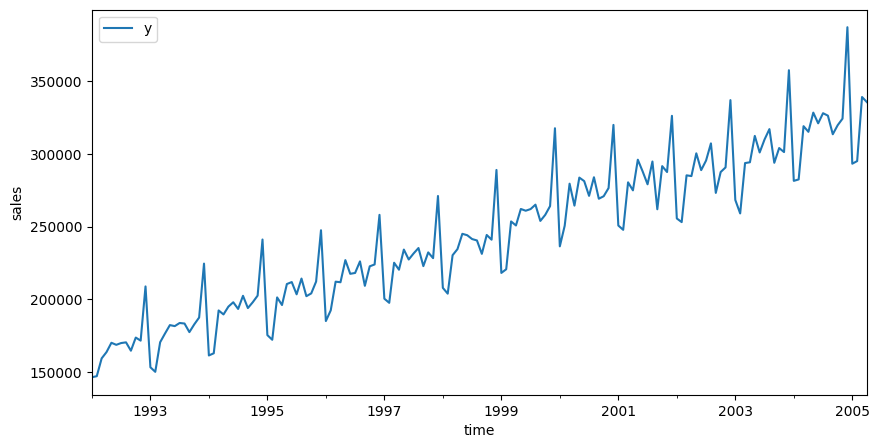

In [3]:
df.plot(figsize=(10,5))
plt.xlabel("time")
plt.ylabel("sales")
plt.show()

## Seasonality

Check for some obvious seasonality patterns. Group time series by some time component, take the mean, and plot it.

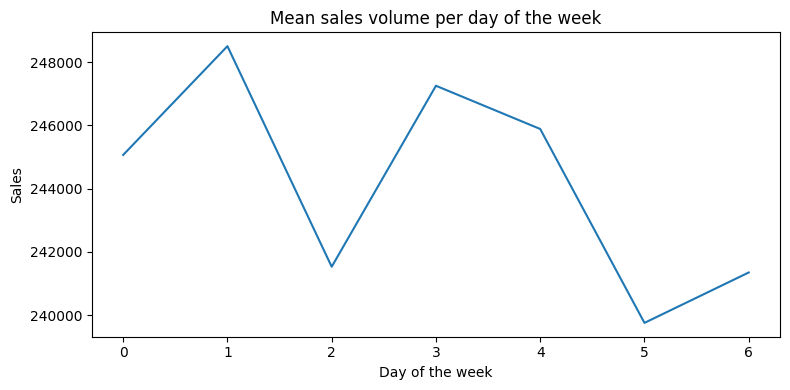

In [4]:
day = df.index.dayofweek

df.groupby(day).mean(numeric_only=True)["y"].plot(figsize=(8,4))

# plot
plt.ylabel("Sales")
plt.xlabel("Day of the week")
plt.title('Mean sales volume per day of the week')
plt.tight_layout()

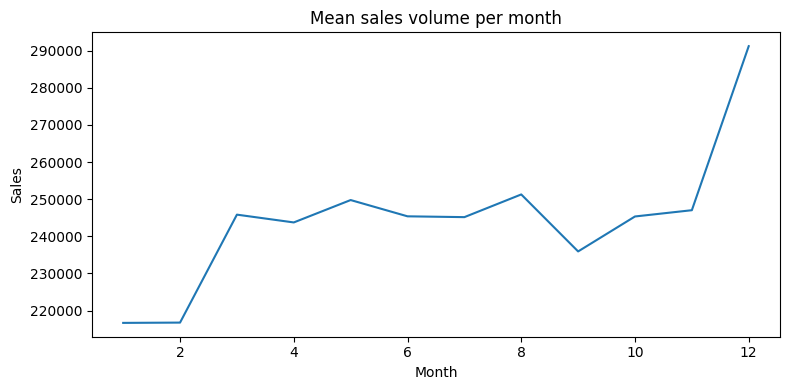

In [5]:
month = df.index.month

df.groupby(month).mean(numeric_only=True)["y"].plot(figsize=(8,4))

# plot
plt.ylabel("Sales")
plt.xlabel("Month")
plt.title('Mean sales volume per month')
plt.tight_layout()

### Which obvious components does this time series show?

The time series has a trend and at least monthly seasonality.

## Split data into train and test

Leave data from 2004 onwards in the test set.

In [6]:
end_train = '2003-12-31'

X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

In [7]:
X_train.tail()

,y
ds,
2003-08-01,317056
2003-09-01,293890
2003-10-01,304036
2003-11-01,301265
2003-12-01,357577


In [8]:
X_test.head()

,y
ds,
2004-01-01,281460
2004-02-01,282444
2004-03-01,319077
2004-04-01,315191
2004-05-01,328408


## Set up regression model

We will use Lasso in this assignment.

In [9]:
# Lasso regression model
# datetime and sales are not in the
# same scale, so we need to scale the variables

model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lasso", Lasso(random_state=9, alpha=10))
])

## Train a Lasso to forecast sales

We'll use recursive forecasting in this assignment.

You can create as many features as you want. This is your opportunity to practice what you've learned. Explore and have fun.

In [10]:
# input to the datetime features

# the index needs to match with the series we
# want to forecast

datetime_df = pd.DataFrame(
    X_train.index,
    index=X_train.index,
)

datetime_df

,ds
ds,
1992-01-01,1992-01-01
1992-02-01,1992-02-01
1992-03-01,1992-03-01
1992-04-01,1992-04-01
1992-05-01,1992-05-01
...,...
2003-08-01,2003-08-01
2003-09-01,2003-09-01
2003-10-01,2003-10-01


In [11]:
datetime_f = DatetimeFeatures(
    variables = "ds",
    features_to_extract = ["month", "day_of_week"],
    drop_original=True,
)

In [12]:
forecaster = ForecasterRecursive(
    regressor=model,              # the machine learning model
    lags=12,                      # the lag features to create
    transformer_exog=datetime_f,  # to get the datetime features
    forecaster_id="recursive"
)

In [13]:
# Fit the model to the data

forecaster.fit(
    y=X_train["y"],     # the series for the lags
    exog=datetime_df,   # the datetime for the datetime features
)

forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=10, random_state=9))]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week'], variables='ds') 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['ds'] 
Training range: [Timestamp('1992-01-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'lasso__alpha': 10, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 9, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'l

In [14]:
# Check the predictor features table created by skforecast.

# These are the input to the Lasso, so it's important to know
# what we are using for training:

X, y = forecaster.create_train_X_y(
    y=X_train["y"],
    exog=datetime_df,
)

X, y

(               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
 ds                                                                       
 1993-01-01  208838.0  171547.0  173655.0  164617.0  170364.0  169890.0   
 1993-02-01  153221.0  208838.0  171547.0  173655.0  164617.0  170364.0   
 1993-03-01  150087.0  153221.0  208838.0  171547.0  173655.0  164617.0   
 1993-04-01  170439.0  150087.0  153221.0  208838.0  171547.0  173655.0   
 1993-05-01  176456.0  170439.0  150087.0  153221.0  208838.0  171547.0   
 ...              ...       ...       ...       ...       ...       ...   
 2003-08-01  309923.0  300998.0  312389.0  294251.0  293693.0  259051.0   
 2003-09-01  317056.0  309923.0  300998.0  312389.0  294251.0  293693.0   
 2003-10-01  293890.0  317056.0  309923.0  300998.0  312389.0  294251.0   
 2003-11-01  304036.0  293890.0  317056.0  309923.0  300998.0  312389.0   
 2003-12-01  301265.0  304036.0  293890.0  317056.0  309923.0  300998.0   
 
                lag_7  

## Forecast next 3 months of sales

Predict the first 3 months of sales right after the training set.

That is, starting on `2002-01-01`.

In [15]:
# we need to create the table with datetime from
# which the datetime features will be created:

# this date needs to coincide with the forecasting
# horizon

datetime_df_test = pd.DataFrame(
    X_test.head(3).index,
    index=X_test.head(3).index,
)

datetime_df_test.head()

,ds
ds,
2004-01-01,2004-01-01
2004-02-01,2004-02-01
2004-03-01,2004-03-01


In [16]:
# Predict the next 24 hs

predictions = forecaster.predict(
    steps=3,
    exog=datetime_df_test,
)

predictions.head()

2004-01-01    284034.022826
2004-02-01    268854.147268
2004-03-01    308677.758494
Freq: MS, Name: pred, dtype: float64

## Plot the prediction vs real sales

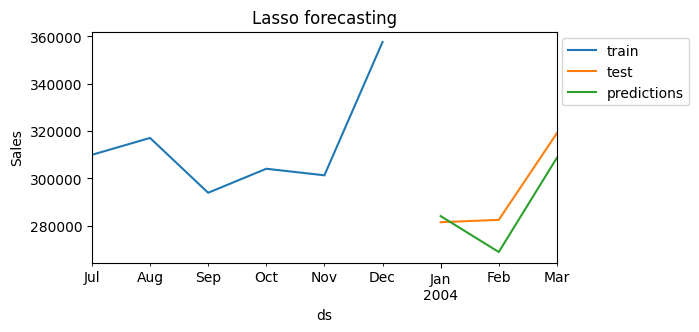

In [17]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(6)["y"].plot(ax=ax, label='train')
X_test.head(3)["y"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel("Sales")
ax.legend(bbox_to_anchor=(1.3, 1.0));

## Determine the RMSE

In [18]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test["y"].head(3),
                y_pred = predictions,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 9990.89443258819


## Forecast future data

Forecast 3 months of sales starting on '2004-12-31'.

In [19]:
forecast_start = '2004-12-31'

# we need sales up to 12 months before this point
# because we are using a lag of 12 
past_data_available = X_test[:forecast_start].tail(12)

# data in the past that we know at the point of forecast
past_data_available.shape

(12, 1)

In [20]:
# we also need the datetime in the date 
# range of the forecasting horizon.

# To make predictions `exog` must start 
# one step ahead of `last_window`.

horizon = X_test[forecast_start:].head(3)

datetime_df_test = pd.DataFrame(
    horizon.index,
    index=horizon.index,
)

datetime_df_test

,ds
ds,
2005-01-01,2005-01-01
2005-02-01,2005-02-01
2005-03-01,2005-03-01


In [21]:
predictions = forecaster.predict(
    steps=3,
    last_window=past_data_available["y"],
    exog=datetime_df_test,
)

predictions

2005-01-01    294427.375181
2005-02-01    295468.556623
2005-03-01    330646.433602
Freq: MS, Name: pred, dtype: float64

## Plot the predictions vs the actuals

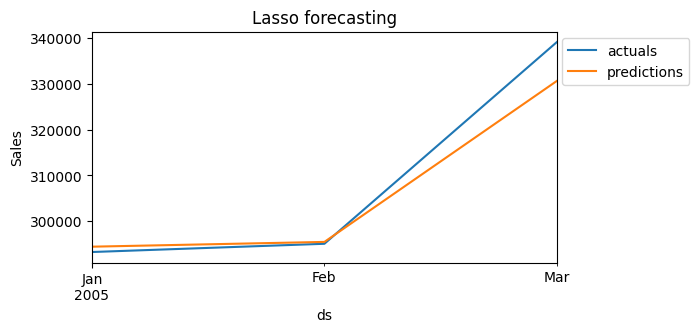

In [22]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
horizon["y"].plot(ax=ax, label='actuals')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel('Sales')
ax.legend(bbox_to_anchor=(1.3, 1.0));

## Determine the RMSE

In [23]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test["y"].head(3),
                y_pred = predictions,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 12538.523147580763
